Molecular Relaxations
===========

Rather than investigating relaxations as an average over all the molecules, we want to investigate individual molecules and how their behaviour is related to that of the aggregate. 

All the simulation data is from a set of simulations stored on RDS in the folder simulations/2017-09-09-dynamics. The set of simulation were all run at a pressure of 13.50 and the data analysed is collected from timesteps on an exponential scale. 

## Setup

This imports the modules nessecary for running the code in the rest of this notebook
while also setting up some helper functions to make the rest of the analysis simpler.

In [2]:
from pathlib import Path
from itertools import permutations

import pandas
import numpy as np
import holoviews as hv
import altair as alt

# Ignore warnings -> bad idea
import warnings
warnings.filterwarnings("ignore")

hv.extension('matplotlib')

def get_temp(fname):
    try:
        return fname.stem.split('-')[3][1:]
    except IndexError:
        return fname.stem.split('-')[2]

def compute_all_ratios(df):
    ratios = {}
    return ratios
    df_collated = df.groupby('init_frame').agg(lambda x: x.mean(skipna=False))
    for val1, val2 in permutations([c.split('_')[1] for c in df.columns], 2):
        ratios.update({
            f'R_{val1}{val2}': (getattr(df, f'tau_{val1}')/getattr(df, f'tau_{val2}')).mean(),
            f'S_{val1}{val2}': (getattr(df, f'tau_{val1}')/getattr(df, f'tau_{val2}')).std(),
            f'Q_{val1}{val2}': getattr(df, f'tau_{val1}').mean() / (1/getattr(df, f'tau_{val2}')).mean(),
            f'X_{val1}{val2}': (getattr(df_collated, f'tau_{val1}').mean() 
                                / (getattr(df_collated, f'tau_{val2}')).mean()),
        })
    return ratios

### Import Data

This reads all the data from disk,
creating a pandas DataFrame and
a Holoviews Table for analysis and plotting of the data. 

In [5]:
source_directory = Path('../data/processed/')

# This computes all the molecular relaxations
dataframes = []
for f in sorted(source_directory.glob('trajectory*.hdf5')):
    try:
        df = pandas.read_hdf(f, 'relaxations')
        df.replace(2**32-1, np.nan, inplace=True)
        df.index.names = ['init_frame', 'molecule']
        df_collated = df.groupby('init_frame').agg(lambda x: x.mean(skipna=False))
        inv_df_collated = df.groupby('init_frame').agg(lambda x: (1/x).mean(skipna=False))
        ratios = {}
        ratios.update({
            'temperature': get_temp(f),
            'tau_rot1': df_collated.tau_T2.mean(),
            'tau_rot2': df_collated.tau_T4.mean(),
            'tau_struct_com': df_collated.tau_D04.mean(),
            'tau_struct_last': df_collated.tau_DL04.mean(),
            'tau_D1': df_collated.tau_D1.mean(),
        })
        dataframes.append(ratios)
    except KeyError:
        pass

# Read in the traditional relaxation constants computed in relaxations.
relaxations = pandas.read_hdf(source_directory / 'dynamics.hdf5', 'relaxations')

In [7]:
relaxations

,Temperature,com_struct,com_struct_err,diffusion,diffusion_err,inv_diffusion,inv_diffusion_err,rot1,rot1_err,rot2,rot2_err,struct,struct_err,struct_msd,struct_msd_err,inv_temp
1.20,1.20,2.428880e+07,771797.461795,8.015918e-09,3.116603e-11,1.247518e+08,-486930.387467,8.030203e+07,1.953623e+06,4.713818e+07,979002.293454,5.161629e+06,422129.789821,96000000.0,1000000.0,0.833333
1.25,1.25,1.424966e+07,405590.555559,3.732021e-08,1.256538e-10,2.679514e+07,-90521.635931,3.376142e+07,3.326688e+05,2.198217e+07,391684.625854,3.665340e+06,301125.291644,35000000.0,1000000.0,0.800000
1.30,1.30,6.300096e+06,256569.716095,1.063234e-07,1.701210e-09,9.405269e+06,-152934.457172,1.718643e+07,6.096828e+05,1.099371e+07,314171.353105,1.733099e+06,203085.120381,20000000.0,1000000.0,0.769231
1.31,1.31,4.954764e+06,190513.736185,1.044415e-07,9.513567e-10,9.574739e+06,-88017.981696,1.665425e+07,3.159740e+05,9.728308e+06,221858.816693,1.239635e+06,156045.724773,20000000.0,1000000.0,0.763359
1.32,1.32,4.069967e+06,124364.502519,1.333371e-07,1.087846e-09,7.499788e+06,-61691.164744,1.182134e+07,3.887617e+05,6.681821e+06,95935.391738,9.730928e+05,112769.303189,14000000.0,1000000.0,0.757576
1.33,1.33,3.465641e+06,101367.782622,1.406469e-07,1.592309e-09,7.110005e+06,-81416.396325,1.026543e+07,2.148030e+05,6.198266e+06,81133.002680,8.527489e+05,92522.375117,11000000.0,1000000.0,0.751880
1.34,1.34,3.379936e+06,90853.585187,2.008002e-07,1.559184e-09,4.980074e+06,-38972.155857,9.352810e+06,1.386150e+05,5.695754e+06,31996.688324,7.632908e+05,87270.500577,11000000.0,1000000.0,0.746269
1.35,1.35,1.785462e+06,71369.575417,2.119971e-07,3.315257e-09,4.717045e+06,-74938.056906,5.263145e+06,1.380022e+04,2.990767e+06,49550.899635,3.888858e+05,32088.444508,6200000.0,100000.0,0.740741
1.36,1.36,2.979833e+06,78283.096262,2.984192e-07,3.847306e-09,3.350991e+06,-43766.173742,7.953253e+06,6.653544e+04,4.541832e+06,32799.372732,6.061879e+05,65824.556409,7900000.0,100000.0,0.735294
1.37,1.37,9.567042e+05,43085.715905,2.977525e-07,6.815773e-09,3.358495e+06,-78679.451529,3.975849e+06,1.420838e+03,1.961499e+06,44944.895110,2.635439e+05,20836.459118,3700000.0,100000.0,0.729927


### Controlling figure layout

The following options control how all the figures are plotted. 

In [6]:
rc_params = {
    'lines.markersize': 6,
    'legend.markerscale': 1,
    'legend.frameon':  False, 
}
%opts Scatter [logx=False logy=True labelled=['x'] fig_rcparams=rc_params]
%opts Overlay [legend_position='top_left' fig_rcparams=rc_params]
%output size=120 dpi=150 fig='pdf'

In [4]:
mol_relax = pandas.DataFrame.from_records(dataframes)
mol_relax.temperature = mol_relax.temperature.astype(float)
mol_relax.index = mol_relax.temperature
mol_relax['inv_temp'] = 1./mol_relax.temperature
# mol_relax = pandas.concat([values, mol_relax, summary_vals], axis=1)
mol_table = hv.Table(mol_relax, kdims=[('inv_temp', '1/T')])
relax_table = hv.Table(relaxations, kdims=[('inv_temp', '1/T')])

:Overlay
   .Scatter.Reverse_over_tau_D                                                             :Scatter   [inv_temp]   (tau_D1)
   .Scatter.Reverse_over_tau_S                                                             :Scatter   [inv_temp]   (tau_struct_com)
   .Scatter.Reverse_over_tau_left_curly_bracket_reverse_over_pi_over_2_right_curly_bracket :Scatter   [inv_temp]   (tau_rot1)
   .Scatter.Reverse_over_tau_left_curly_bracket_reverse_over_pi_over_4_right_curly_bracket :Scatter   [inv_temp]   (tau_rot2)
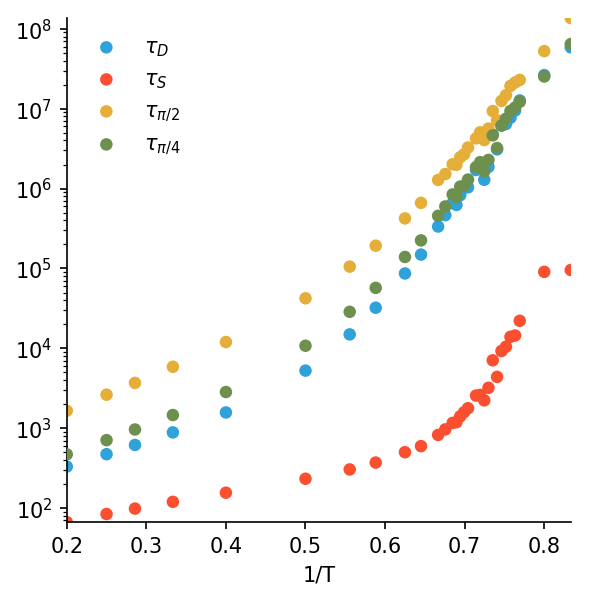

In [5]:
(
    mol_table.to(hv.Scatter, vdims=['tau_D1'], label=r'$\tau_D$') * 
    mol_table.to(hv.Scatter, vdims='tau_struct_com', label=r'$\tau_S$') *
    mol_table.to(hv.Scatter, vdims=['tau_rot1'], label=r'$\tau_{\pi/2}$') * 
    mol_table.to(hv.Scatter, vdims='tau_rot2', label=r'$\tau_{\pi/4}$')
) 

:Overlay
   .Scatter.Reverse_over_langle_reverse_over_tau_left_curly_bracket_D1_right_curly_bracket_reverse_over_rangle :Scatter   [inv_temp]   (tau_D1)
   .Scatter.A_1_over_D                                                                                         :Scatter   [inv_temp]   (inv_diffusion)
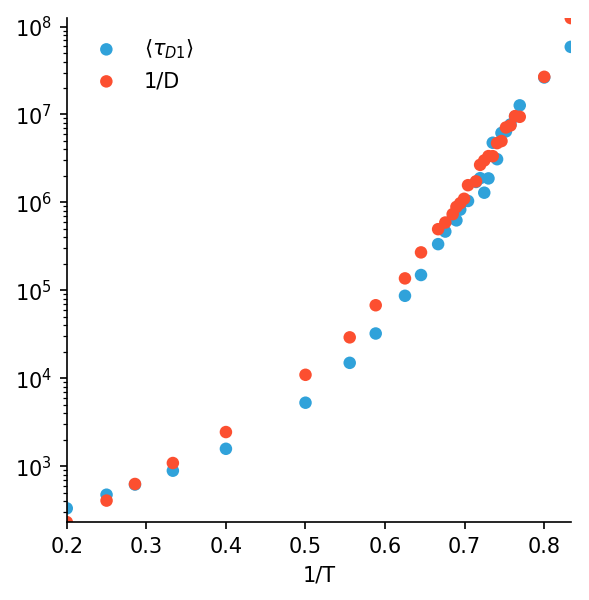

In [6]:
(
    mol_table.to(hv.Scatter, vdims=['tau_D1'], label=r'$\langle \tau_{D1}\rangle$') * 
    relax_table.to(hv.Scatter, vdims='inv_diffusion', label=r'1/D')
) 

:Overlay
   .Scatter.Reverse_over_langle_reverse_over_tau_left_curly_bracket_D0_full_stop_4_right_curly_bracket_reverse_over_rangle  :Scatter   [inv_temp]   (tau_struct_com)
   .Scatter.Reverse_over_langle_reverse_over_tau_left_curly_bracket_DL0_full_stop_4_right_curly_bracket_reverse_over_rangle :Scatter   [inv_temp]   (tau_struct_last)
   .Scatter.Reverse_over_tau_left_curly_bracket_MSD_right_curly_bracket                                                     :Scatter   [inv_temp]   (struct_msd)
   .Scatter.Reverse_over_tau_S                                                                                              :Scatter   [inv_temp]   (com_struct)
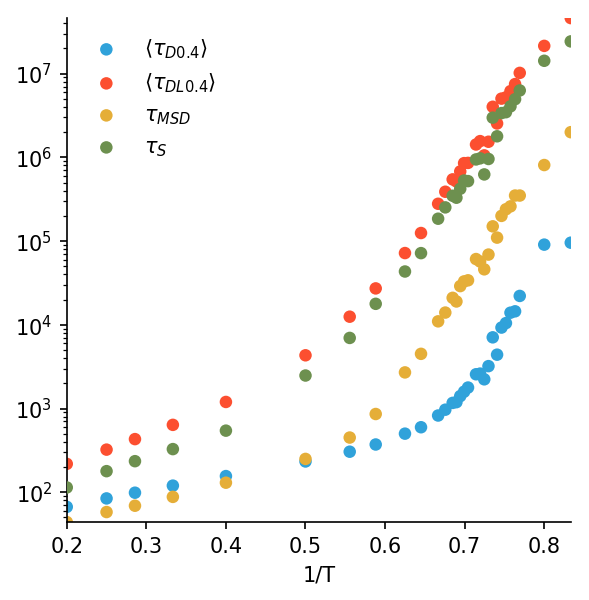

In [7]:
(
    mol_table.to(hv.Scatter, vdims='tau_struct_com', label=r'$\langle \tau_{D0.4} \rangle$') *
    mol_table.to(hv.Scatter, vdims='tau_struct_last', label=r'$\langle\tau_{DL0.4} \rangle$') *
    relax_table.to(hv.Scatter, vdims='struct_msd', label=r'$\tau_{MSD}$') *
    relax_table.to(hv.Scatter, vdims='com_struct', label=r'$\tau_S$')
)

:Overlay
   .Scatter.Reverse_over_langle_reverse_over_tau_left_curly_bracket_reverse_over_pi_over_2_right_curly_bracket_reverse_over_rangle :Scatter   [inv_temp]   (tau_rot1)
   .Scatter.Reverse_over_tau_left_curly_bracket_R1_right_curly_bracket                                                             :Scatter   [inv_temp]   (rot1)
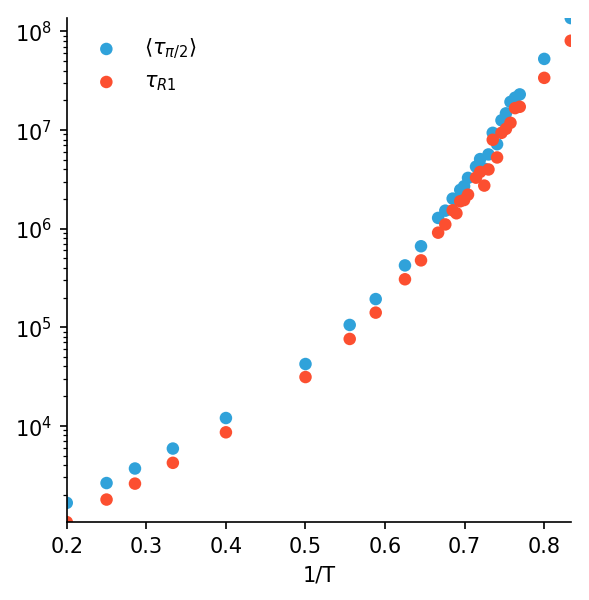

In [8]:
(
    mol_table.to(hv.Scatter, vdims=['tau_rot1'], label=r'$\langle \tau_{\pi/2} \rangle$') * 
    relax_table.to(hv.Scatter, vdims=['rot1'], label=r'$\tau_{R1}$')
)

:Overlay
   .Scatter.Reverse_over_langle_reverse_over_tau_left_curly_bracket_reverse_over_pi_over_4_right_curly_bracket_reverse_over_rangle :Scatter   [inv_temp]   (tau_rot2)
   .Scatter.Reverse_over_tau_left_curly_bracket_R2_right_curly_bracket                                                             :Scatter   [inv_temp]   (rot2)
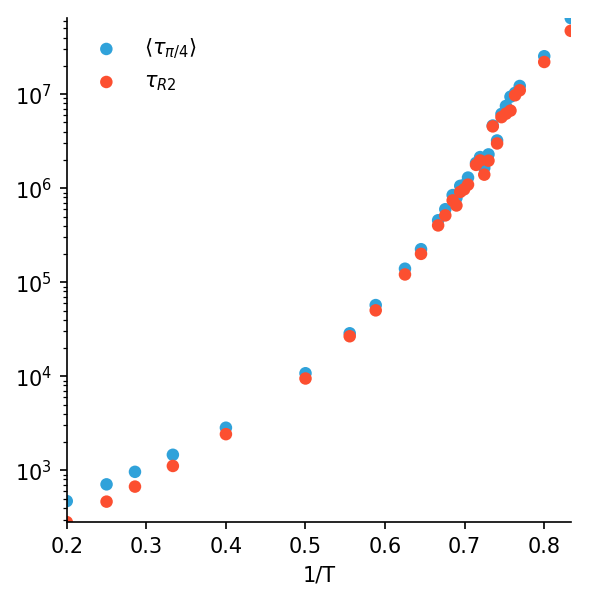

In [9]:
(
    mol_table.to(hv.Scatter, vdims=['tau_rot2'], label=r'$\langle \tau_{\pi/4} \rangle$') * 
    relax_table.to(hv.Scatter, vdims=['rot2'], label=r'$\tau_{R2}$')
)

:Overlay
   .Scatter.Reverse_over_langle_reverse_over_tau_left_curly_bracket_reverse_over_pi_over_4_right_curly_bracket_reverse_over_rangle :Scatter   [tau_D1]   (tau_rot2)
   .Scatter.A_1_over_D                                                                                                             :Scatter   [tau_D1]   (inv_diffusion)
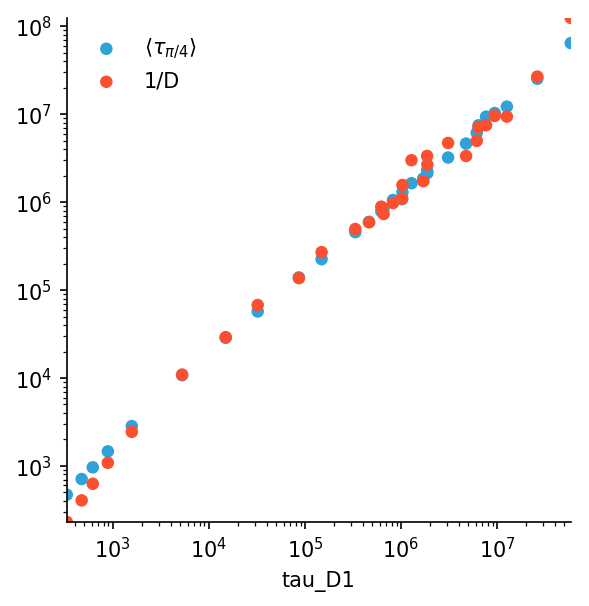

In [10]:
%%opts Scatter [logy=True logx=True]
all_table = pandas.concat([mol_relax, relaxations], axis=1)

(
    hv.Scatter(all_table, kdims=['tau_D1'], vdims=['tau_rot2'], label=r'$\langle \tau_{\pi/4}\rangle$') * 
    hv.Scatter(all_table, kdims=['tau_D1'], vdims=['inv_diffusion'], label='1/D')
)

:Scatter   [tau_struct_com]   (tau_D1)
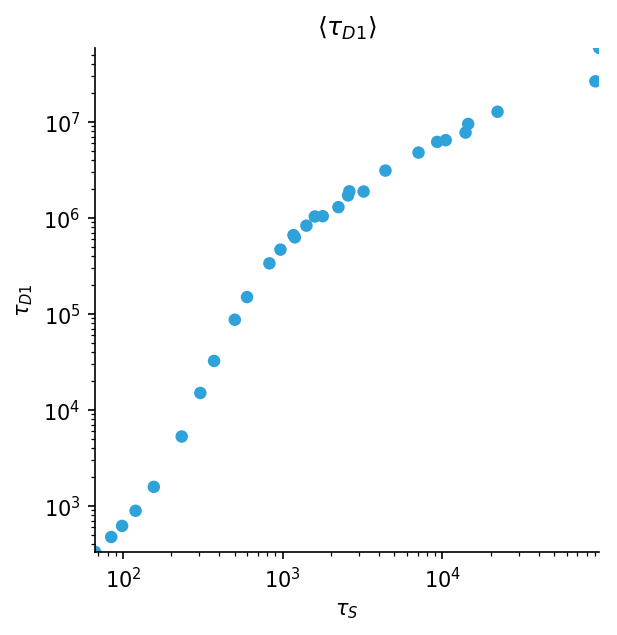

In [11]:
%%opts Scatter [logy=True logx=True labelled=['x', 'y']]

hv.Scatter(all_table, kdims=[('tau_struct_com', r'$\tau_S$')], vdims=[('tau_D1', r'$\tau_{D1}$')], label=r'$\langle\tau_{D1}\rangle$')

:Overlay
   .Scatter.Reverse_over_langle_reverse_over_tau_left_curly_bracket_D1_right_curly_bracket_reverse_over_rangle             :Scatter   [inv_temp]   (tau_D1)
   .Scatter.Reverse_over_langle_reverse_over_tau_left_curly_bracket_D0_full_stop_4_right_curly_bracket_reverse_over_rangle :Scatter   [inv_temp]   (tau_struct_com)
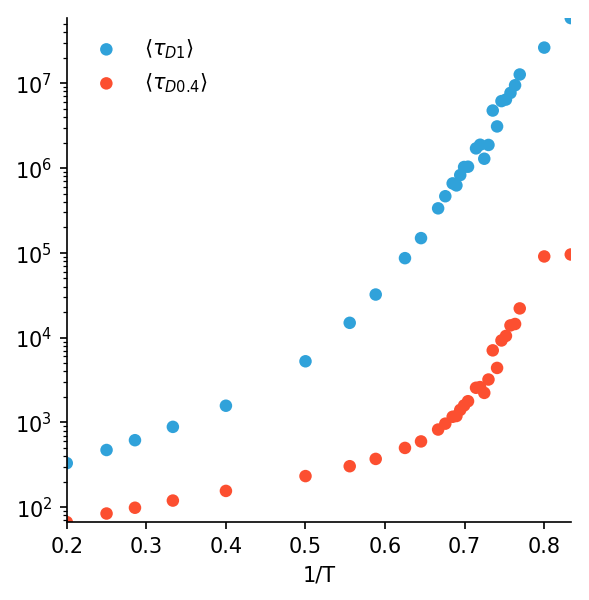

In [12]:
%%opts Scatter [logx=False logy=True]

(
    hv.Scatter(mol_table, kdims=[('inv_temp', '1/T')], vdims=['tau_D1'], label=r'$\langle\tau_{D1}\rangle$') *
    hv.Scatter(mol_table, kdims=['inv_temp'], vdims=['tau_struct_com'], label=r'$\langle\tau_{D0.4}\rangle$')
)

In [13]:
%%opts Scatter [logx=False logy=False]

data = {
    'temp': mol_relax.temperature,
    'vals': mol_relax.tau_struct_com/mol_relax.tau_struct_last
}
(
    hv.Scatter(data, kdims=[('temp', 'T')], 
               vdims=[('vals','<τ_D0.4>/<τ_D1>')], 
               label='\langle \tau_{D0.4}\rangle/\langle \tau_{D1}\rangle')
)

Exception: Please use a raw string or escape control code '\r'

:Scatter   [temp]   (vals)

:Overlay
   .Scatter.Reverse_over_langle_reverse_over_tau_left_curly_bracket_DL0_full_stop_4_right_curly_bracket_reverse_over_rangle :Scatter   [inv_diffusion]   (tau_struct_last)
   .Scatter.Reverse_over_tau_S                                                                                              :Scatter   [inv_diffusion]   (com_struct)
   .Scatter.Reverse_over_tau_left_curly_bracket_MSD_right_curly_bracket                                                     :Scatter   [inv_diffusion]   (struct_msd)
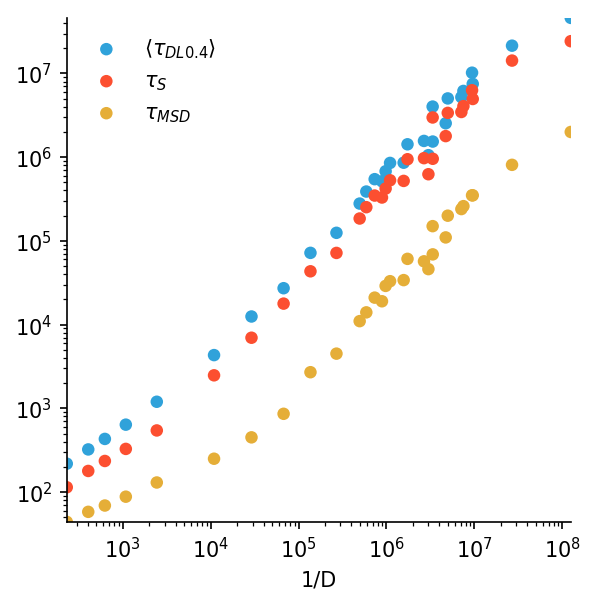

In [14]:
%%opts Scatter [logx=True logy=True]

( 
    hv.Scatter(all_table, kdims=[('inv_diffusion', '1/D')], vdims=['tau_struct_last'], label=r'$\langle\tau_{DL0.4}\rangle$') *
    hv.Scatter(all_table, kdims=['inv_diffusion'], vdims=['com_struct'], label=r'$\tau_S$') *
    hv.Scatter(all_table, kdims=['inv_diffusion'], vdims=['struct_msd'], label=r'$\tau_{MSD}$') 
)